## **Download needed packages and conneting to dirve:** 

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [9]:
%cd /content/drive/My Drive/Phase2_ML_for_Bio_Project

/content/drive/My Drive/GraphDTA-master


In [ ]:
!pip3 install torch-scatter==latest+cu101 -f https://pytorch-geometric.com/whl/torch-1.6.0.html
!pip3 install torch-sparse==latest+cu101 -f https://pytorch-geometric.com/whl/torch-1.6.0.html
!pip3 install torch-cluster==latest+cu101 -f https://pytorch-geometric.com/whl/torch-1.6.0.html
!pip3 install torch-spline-conv==latest+cu101 -f https://pytorch-geometric.com/whl/torch-1.6.0.html
!pip3 install torch-geometric

In [ ]:
!wget -c https://repo.continuum.io/miniconda/Miniconda3-py37_4.8.3-Linux-x86_64.sh
!chmod +x Miniconda3-py37_4.8.3-Linux-x86_64.sh
!time bash ./Miniconda3-py37_4.8.3-Linux-x86_64.sh -b -f -p /usr/local
!time conda install -q -y -c conda-forge rdkit

import sys
sys.path.append('/usr/local/lib/python3.7/site-packages/')

In [ ]:
!sudo pip3 install networkx

## **Dataset:** 

In [13]:
import os
import numpy as np
from math import sqrt
from scipy import stats
from torch_geometric.data import InMemoryDataset, DataLoader
from torch_geometric import data as DATA
import torch

class TestbedDataset(InMemoryDataset):
    def __init__(self, root='/tmp', dataset='davis', 
                 xd=None, xt=None, y=None, transform=None,
                 pre_transform=None,smile_graph=None):

        #root is required for save preprocessed data, default is '/tmp'
        super(TestbedDataset, self).__init__(root, transform, pre_transform)
        # benchmark dataset, default = 'davis'
        self.dataset = dataset
        print(self.processed_paths[0])
        if os.path.isfile(self.processed_paths[0]):
            print('Pre-processed data found: {}, loading ...'.format(self.processed_paths[0]))
            self.data, self.slices = torch.load(self.processed_paths[0])
        else:
            print('Pre-processed data {} not found, doing pre-processing...'.format(self.processed_paths[0]))
            self.process(xd, xt, y,smile_graph)
            self.data, self.slices = torch.load(self.processed_paths[0])

    @property
    def raw_file_names(self):
        pass
        #return ['some_file_1', 'some_file_2', ...]

    @property
    def processed_file_names(self):
        return [self.dataset + '.pt']

    def download(self):
        # Download to `self.raw_dir`.
        pass

    def _download(self):
        pass

    def _process(self):
        if not os.path.exists(self.processed_dir):
            os.makedirs(self.processed_dir)

    # Customize the process method to fit the task of drug-target affinity prediction
    # Inputs:
    # XD - list of SMILES, XT: list of encoded target (categorical or one-hot),
    # Y: list of labels (i.e. affinity)
    # Return: PyTorch-Geometric format processed data
    def process(self, xd, xt, y,smile_graph):
        assert (len(xd) == len(xt) and len(xt) == len(y)), "The three lists must be the same length!"
        data_list = []
        data_len = len(xd)
        for i in range(data_len):
            # print('Converting SMILES to graph: {}/{}'.format(i+1, data_len))
            smiles = xd[i]
            target = xt[i]
            labels = y[i]
            # convert SMILES to molecular representation using rdkit
            c_size, features, edge_index = smile_graph[smiles]
            # make the graph ready for PyTorch Geometrics GCN algorithms:
            GCNData = DATA.Data(x=torch.Tensor(features),
                                edge_index=torch.LongTensor(edge_index).transpose(1, 0),
                                y=torch.FloatTensor([labels]))
            GCNData.target = torch.LongTensor([target])
            GCNData.__setitem__('c_size', torch.LongTensor([c_size]))
            # append graph, label and target sequence to data list
            data_list.append(GCNData)

        if self.pre_filter is not None:
            data_list = [data for data in data_list if self.pre_filter(data)]

        if self.pre_transform is not None:
            data_list = [self.pre_transform(data) for data in data_list]
        print('Graph construction done. Saving to file.')
        data, slices = self.collate(data_list)
        # save preprocessed data:
        torch.save((data, slices), self.processed_paths[0])

def rmse(y,f):
    rmse = sqrt(((y - f)**2).mean(axis=0))
    return rmse
def mse(y,f):
    mse = ((y - f)**2).mean(axis=0)
    return mse
def pearson(y,f):
    rp = np.corrcoef(y, f)[0,1]
    return rp
def spearman(y,f):
    rs = stats.spearmanr(y, f)[0]
    return rs
def ci(y,f):
    ind = np.argsort(y)
    y = y[ind]
    f = f[ind]
    i = len(y)-1
    j = i-1
    z = 0.0
    S = 0.0
    while i > 0:
        while j >= 0:
            if y[i] > y[j]:
                z = z+1
                u = f[i] - f[j]
                if u > 0:
                    S = S + 1
                elif u == 0:
                    S = S + 0.5
            j = j - 1
        i = i - 1
        j = i-1
    ci = S/z
    return ci

## **Preparing the Dataset:** 

In [ ]:
import pandas as pd
import numpy as np
import os
import json,pickle
from collections import OrderedDict
from rdkit import Chem
from rdkit.Chem import MolFromSmiles, Draw
import networkx as nx
from rdkit import Chem
# from utils import *

def atom_features(atom):
    return np.array(one_of_k_encoding_unk(atom.GetSymbol(),['C', 'N', 'O', 'S', 'F', 'Si', 'P', 'Cl', 'Br', 'Mg', 'Na','Ca', 'Fe', 'As', 'Al', 'I', 'B', 'V', 'K', 'Tl', 'Yb','Sb', 'Sn', 'Ag', 'Pd', 'Co', 'Se', 'Ti', 'Zn', 'H','Li', 'Ge', 'Cu', 'Au', 'Ni', 'Cd', 'In', 'Mn', 'Zr','Cr', 'Pt', 'Hg', 'Pb', 'Unknown']) +
                    one_of_k_encoding(atom.GetDegree(), [0, 1, 2, 3, 4, 5, 6,7,8,9,10]) +
                    one_of_k_encoding_unk(atom.GetTotalNumHs(), [0, 1, 2, 3, 4, 5, 6,7,8,9,10]) +
                    one_of_k_encoding_unk(atom.GetImplicitValence(), [0, 1, 2, 3, 4, 5, 6,7,8,9,10]) +
                    [atom.GetIsAromatic()])

def one_of_k_encoding(x, allowable_set):
    if x not in allowable_set:
        raise Exception("input {0} not in allowable set{1}:".format(x, allowable_set))
    return list(map(lambda s: x == s, allowable_set))

def one_of_k_encoding_unk(x, allowable_set):
    """Maps inputs not in the allowable set to the last element."""
    if x not in allowable_set:
        x = allowable_set[-1]
    return list(map(lambda s: x == s, allowable_set))

def smile_to_graph(smile):
    mol = Chem.MolFromSmiles(smile)
    c_size = mol.GetNumAtoms()
    
    features = []
    for atom in mol.GetAtoms():
        feature = atom_features(atom)
        features.append( feature / sum(feature) )

    edges = []
    for bond in mol.GetBonds():
        edges.append([bond.GetBeginAtomIdx(), bond.GetEndAtomIdx()])
    g = nx.Graph(edges).to_directed()
    edge_index = []
    for e1, e2 in g.edges:
        edge_index.append([e1, e2])
        
    return c_size, features, edge_index

def seq_cat(prot):
    x = np.zeros(max_seq_len)
    for i, ch in enumerate(prot[:max_seq_len]): 
        x[i] = seq_dict[ch]
    return x  


# from DeepDTA data
all_prots = []
datasets = ['kiba','davis']
for dataset in datasets:
    print('convert data from DeepDTA for ', dataset)
    fpath = 'data/' + dataset + '/'
    train_fold_j = json.load(open(fpath + "folds/train_fold_setting1.txt"))
    # print(train_fold_j)
    # print(len(train_fold_j),len(train_fold_j[0:4]),len(train_fold_j[0]))
    train_fold = [ee for e in train_fold_j[0:4] for ee in e ]
    valid_fold = [ee for e in train_fold_j[4:5] for ee in e ]
    # print(len(train_fold))
    test_fold = json.load(open(fpath + "folds/test_fold_setting1.txt"))
    # print("test fold",test_fold)
    ligands = json.load(open(fpath + "ligands_can.txt"), object_pairs_hook=OrderedDict)
    # print(len(ligands))
    # print(ligands)
    proteins = json.load(open(fpath + "proteins.txt"), object_pairs_hook=OrderedDict)
    # print(len(proteins))
    # print(proteins)
    affinity = pickle.load(open(fpath + "Y","rb"), encoding='latin1')
    # print(affinity.shape)
    drugs = []
    prots = []
    for d in ligands.keys():
        lg = Chem.MolToSmiles(Chem.MolFromSmiles(ligands[d]),isomericSmiles=True)
        drugs.append(lg)
    # print(drugs)
    for t in proteins.keys():
        prots.append(proteins[t])
    # print(prots)
    if dataset == 'davis':
        affinity = [-np.log10(y/1e9) for y in affinity]
    affinity = np.asarray(affinity)
    # print(affinity)
    opts = ['train','valid','test']
    for opt in opts:
        rows, cols = np.where(np.isnan(affinity)==False)  
        # print(rows, cols)
        # print(len(rows), len(cols))
        if opt=='train':
            rows,cols = rows[train_fold], cols[train_fold]
            # print(rows, cols)
            # print(len(rows), len(cols))
        elif opt=='valid':
            rows,cols = rows[valid_fold], cols[valid_fold]
            # print(rows, cols)
            # print(len(rows), len(cols))
        elif opt=='test':
            rows,cols = rows[test_fold], cols[test_fold]
            # print(rows, cols)
            # print(len(rows), len(cols))
        with open('data/' + dataset + '_' + opt + '.csv', 'w') as f:
            f.write('compound_iso_smiles,target_sequence,affinity\n')
            for pair_ind in range(len(rows)):
                ls = []
                ls += [ drugs[rows[pair_ind]]  ]
                ls += [ prots[cols[pair_ind]]  ]
                ls += [ affinity[rows[pair_ind],cols[pair_ind]]  ]
                f.write(','.join(map(str,ls)) + '\n')       
    print('\ndataset:', dataset)
    print('train_fold:', len(train_fold))
    print('valid_fold:', len(valid_fold))
    print('test_fold:', len(test_fold))
    print('len(set(drugs)),len(set(prots)):', len(set(drugs)),len(set(prots)))
    all_prots += list(set(prots))
    
    
seq_voc = "ABCDEFGHIKLMNOPQRSTUVWXYZ"
seq_dict = {v:(i+1) for i,v in enumerate(seq_voc)}
# print(seq_dict)
seq_dict_len = len(seq_dict)
max_seq_len = 1000

compound_iso_smiles = []
for dt_name in ['kiba','davis']:
    opts = ['train','valid','test']
    for opt in opts:
        df = pd.read_csv('data/' + dt_name + '_' + opt + '.csv')
        compound_iso_smiles += list( df['compound_iso_smiles'] )

compound_iso_smiles = set(compound_iso_smiles)
smile_graph = {}

for smile in compound_iso_smiles:
    g = smile_to_graph(smile)
    smile_graph[smile] = g

datasets = [['davis','kiba'][0]]
# convert to PyTorch data format
for dataset in datasets:
    processed_data_file_train = 'data/processed/' + dataset + '1_train.pt'
    processed_data_file_valid = 'data/processed/' + dataset + '1_valid.pt'
    processed_data_file_test = 'data/processed/' + dataset + '1_test.pt'
    if ((not os.path.isfile(processed_data_file_train)) or (not os.path.isfile(processed_data_file_test))):
        # print("here")
        df = pd.read_csv('data/' + dataset + '_train.csv')
        train_drugs, train_prots,  train_Y = list(df['compound_iso_smiles']),list(df['target_sequence']),list(df['affinity'])
        XT = [seq_cat(t) for t in train_prots]
        train_drugs, train_prots,  train_Y = np.asarray(train_drugs), np.asarray(XT), np.asarray(train_Y)
        # print(train_drugs.shape,train_prots.shape,train_Y.shape)
        df = pd.read_csv('data/' + dataset + '_valid.csv')
        valid_drugs, valid_prots,  valid_Y = list(df['compound_iso_smiles']),list(df['target_sequence']),list(df['affinity'])
        XT = [seq_cat(t) for t in valid_prots]
        valid_drugs, valid_prots,  valid_Y = np.asarray(valid_drugs), np.asarray(XT), np.asarray(valid_Y)
        df = pd.read_csv('data/' + dataset + '_test.csv')
        test_drugs, test_prots,  test_Y = list(df['compound_iso_smiles']),list(df['target_sequence']),list(df['affinity'])
        XT = [seq_cat(t) for t in test_prots]
        test_drugs, test_prots,  test_Y = np.asarray(test_drugs), np.asarray(XT), np.asarray(test_Y)

        # make data PyTorch Geometric ready
        print('preparing ', dataset + '_train.pt in pytorch format!')
        train_data = TestbedDataset(root='data', dataset=dataset+'1_train', xd=train_drugs, xt=train_prots, y=train_Y,smile_graph=smile_graph)
        print('preparing ', dataset + '_valid.pt in pytorch format!')
        valid_data = TestbedDataset(root='data', dataset=dataset+'1_valid', xd=train_drugs, xt=train_prots, y=train_Y,smile_graph=smile_graph)
        print('preparing ', dataset + '_test.pt in pytorch format!')
        test_data = TestbedDataset(root='data', dataset=dataset+'1_test', xd=test_drugs, xt=test_prots, y=test_Y,smile_graph=smile_graph)
        print(processed_data_file_train, ' and ', processed_data_file_valid, ' and ', processed_data_file_test, ' have been created')        
    else:
        print(processed_data_file_train, ' and ', processed_data_file_valid, ' and ', processed_data_file_test, ' are already created')        


convert data from DeepDTA for  kiba
[[113703, 51222, 98078, 29622, 80976, 112045, 13772, 30711, 60861, 37749, 81354, 63562, 95894, 4304, 66134, 113956, 101753, 52209, 77547, 4971, 97974, 85713, 81686, 99858, 51677, 51830, 86231, 45031, 33878, 45316, 72556, 112623, 71432, 11026, 117726, 39238, 73687, 106892, 112008, 59984, 20584, 32173, 6841, 74999, 95786, 23836, 62466, 45707, 51576, 72240, 117, 49544, 88312, 111398, 15103, 22355, 92143, 111880, 26589, 24839, 110747, 14799, 32230, 95217, 30087, 90408, 112689, 416, 93706, 76120, 47165, 12294, 14306, 68760, 3054, 68796, 8736, 51287, 13542, 69229, 97411, 67326, 41854, 108201, 99132, 69594, 81827, 70473, 3125, 2960, 47413, 6726, 113540, 3253, 40074, 2847, 88227, 108500, 91813, 97416, 31844, 52855, 77371, 103725, 50609, 78359, 48435, 47636, 42323, 107567, 99630, 34607, 88260, 34501, 48091, 87635, 110657, 72456, 82979, 56454, 100339, 56676, 89649, 587, 30117, 67957, 111577, 57844, 75278, 57147, 62471, 30098, 8515, 24842, 56295, 104700, 73539,

## **Visualization of graph representation of drugs:** 

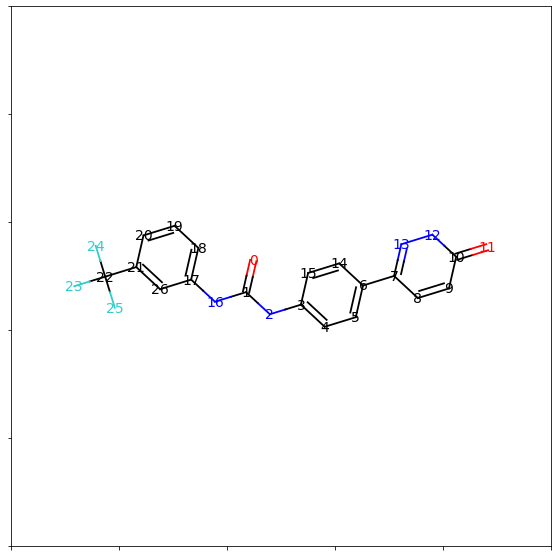

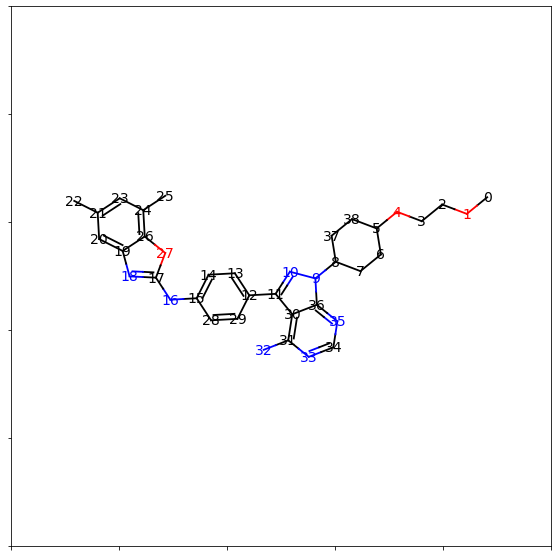

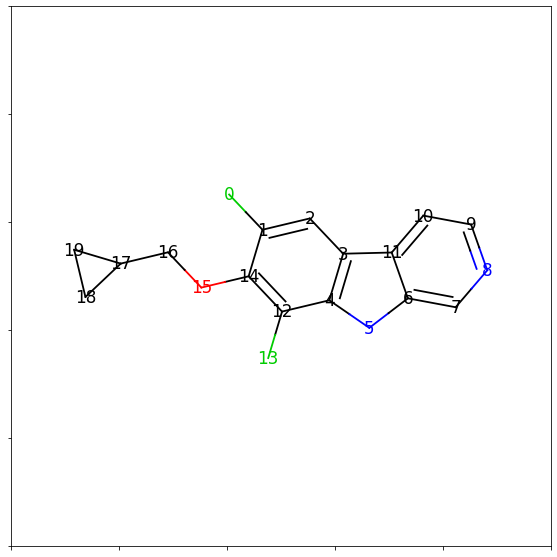

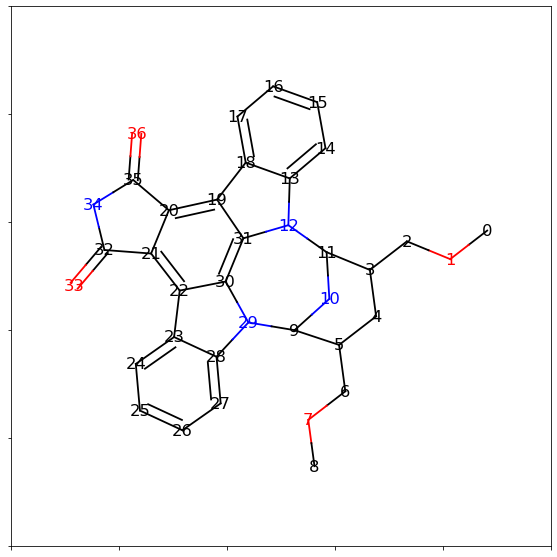

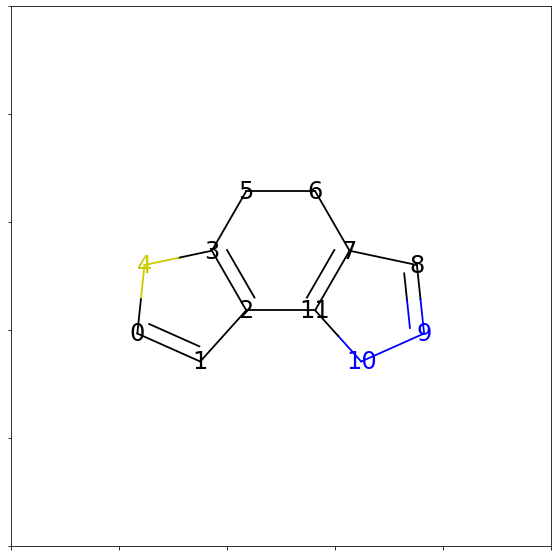

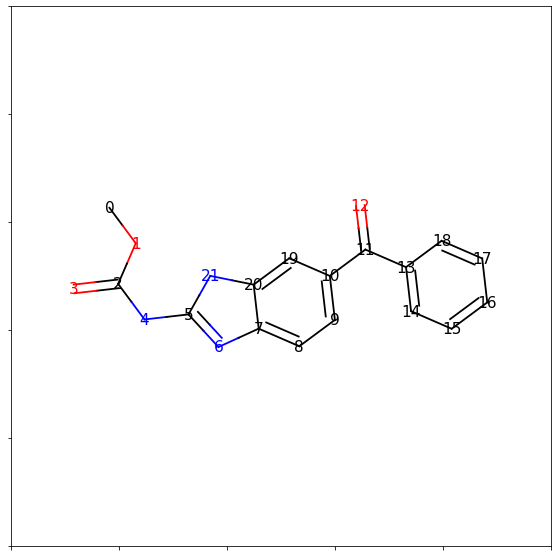

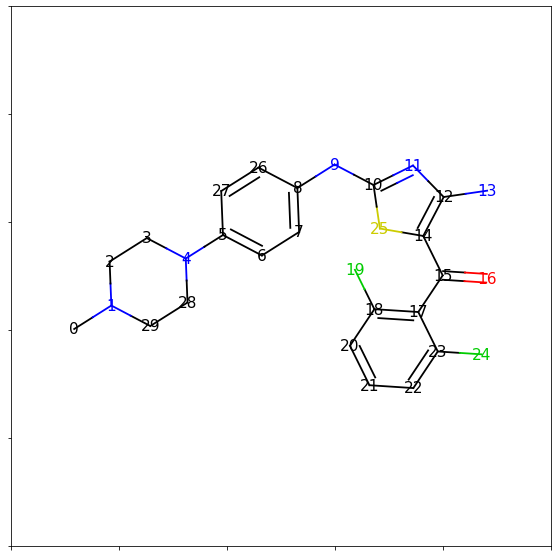

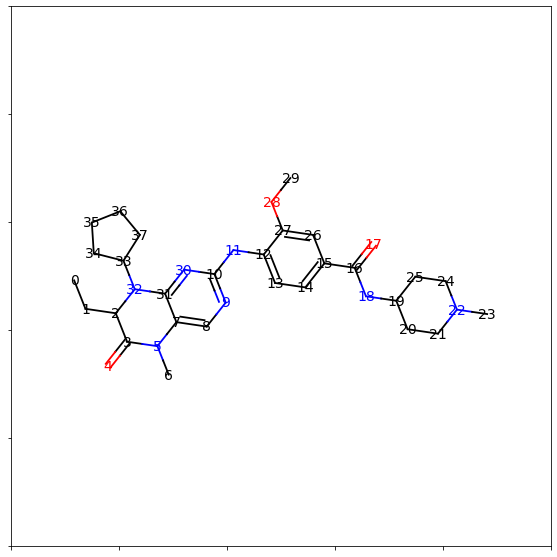

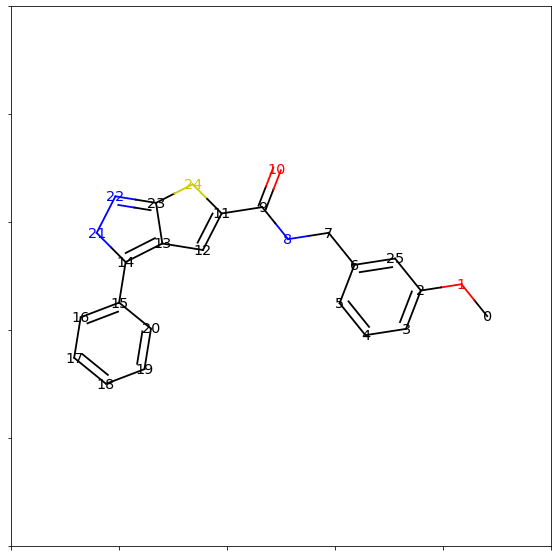

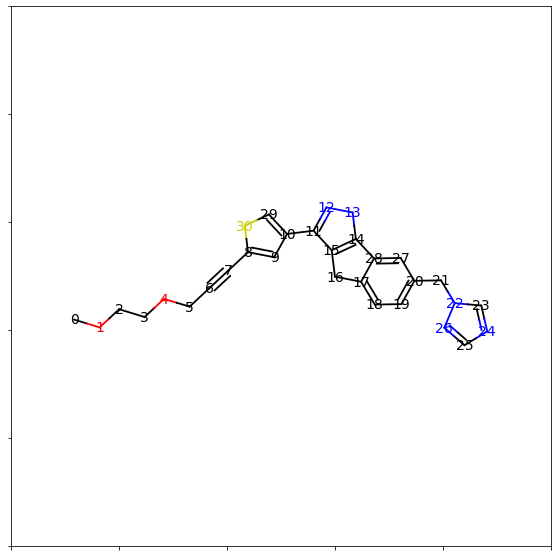

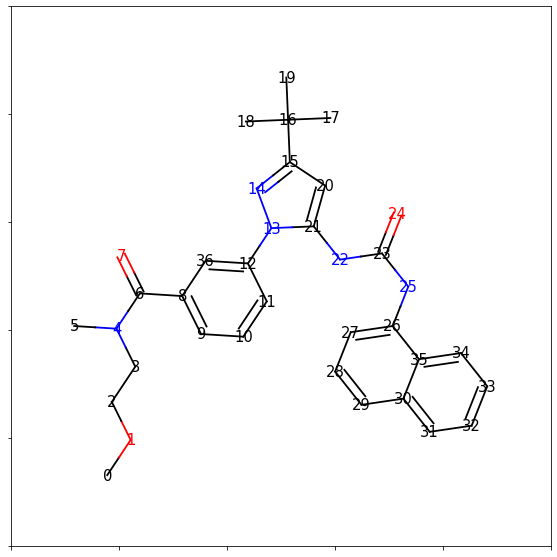

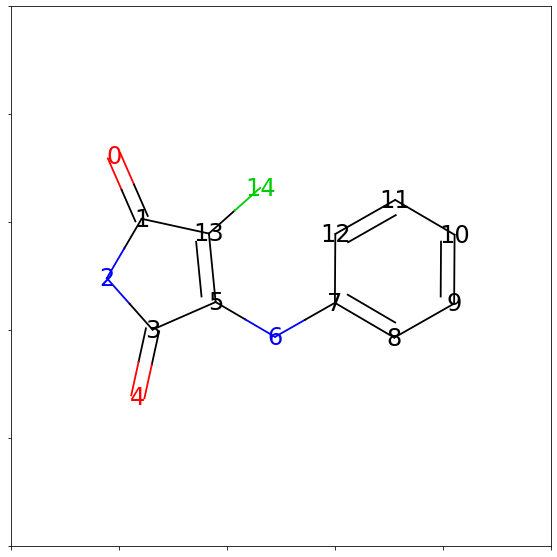

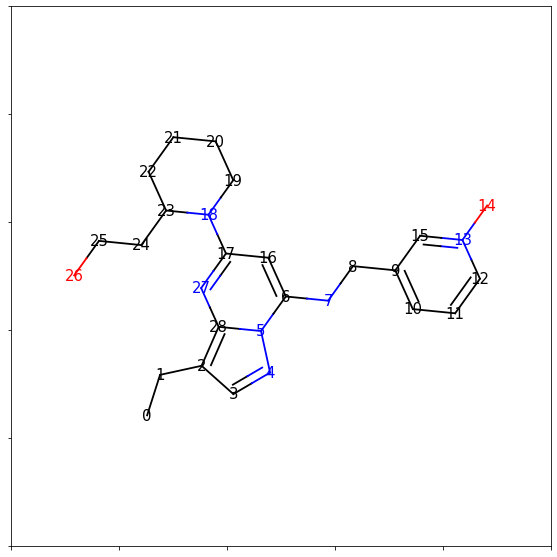

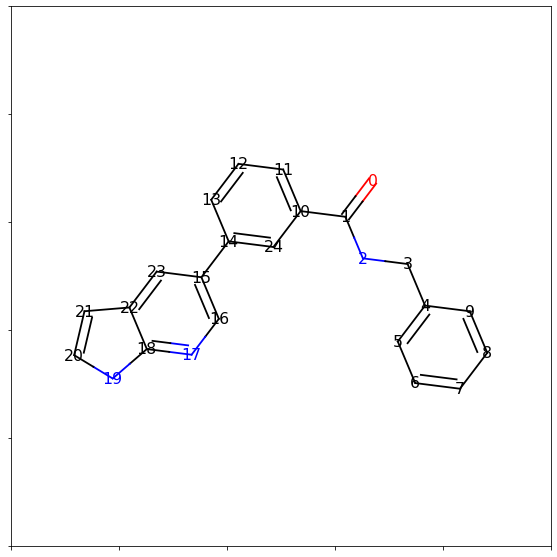

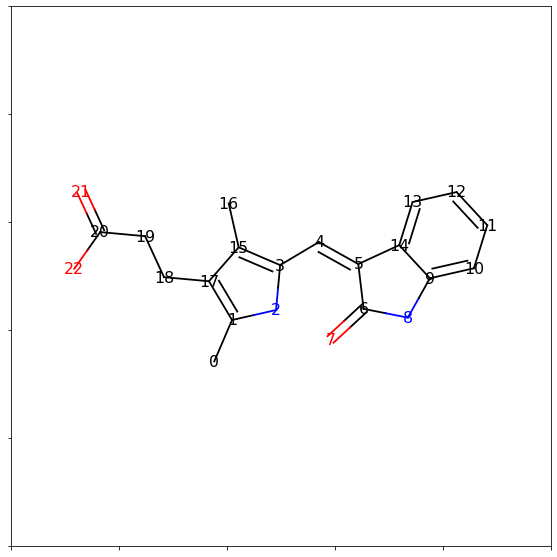

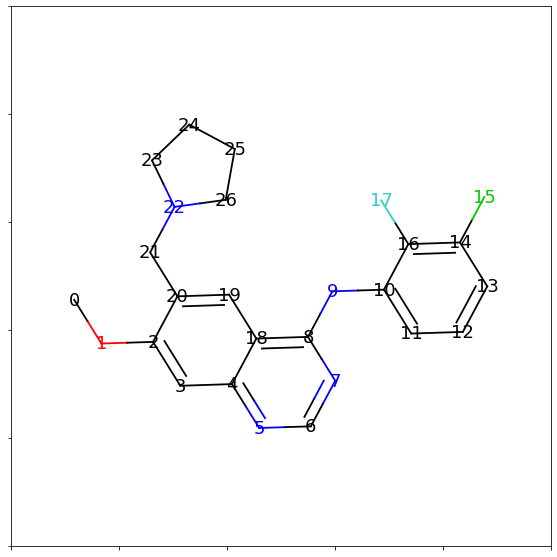

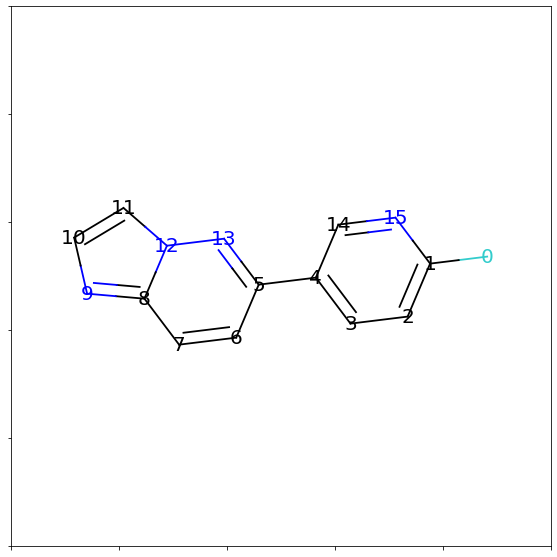

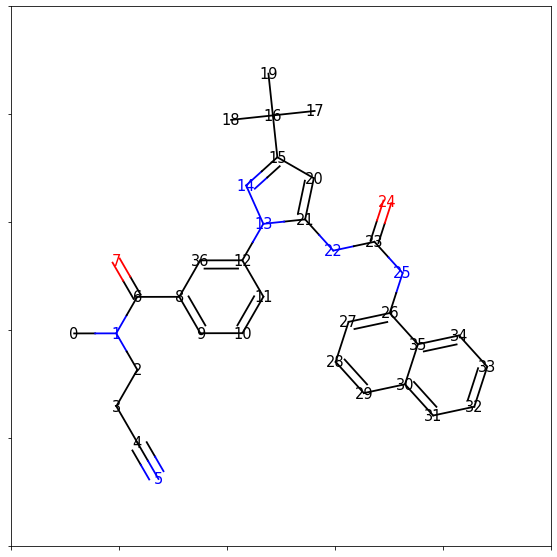

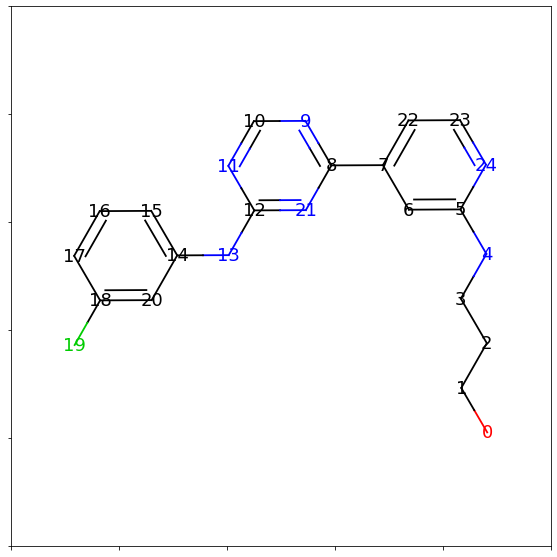

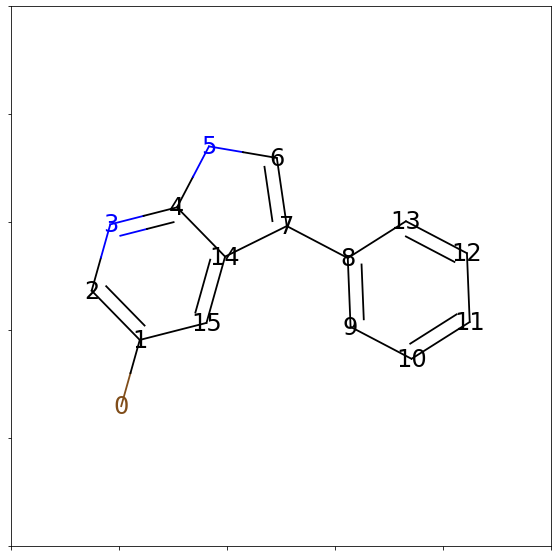

In [ ]:
def smile_to_graph_draw(smile):
    mol = Chem.MolFromSmiles(smile)
    # img = Draw.MolsToImage([mol], subImgSize=(200, 200), legends=None)

    MolToMPL(mol, size=(300, 300))


compound_iso_smiles = []
for dt_name in ['kiba','davis']:
    opts = ['train','valid','test']
    for opt in opts:
        df = pd.read_csv('data/' + dt_name + '_' + opt + '.csv')
        compound_iso_smiles += list( df['compound_iso_smiles'] )

compound_iso_smiles = set(compound_iso_smiles)
n = 0
for smile in compound_iso_smiles:
    if n <20:
        g = smile_to_graph_draw(smile)
    else:
        break
    n+= 1
    # print("============================================")
    # print(len(smile))
    # print(g[0],len(g[1]),len(g[2]))

## **Training and Calculation MSE and CI:** 

In [7]:
import numpy as np
import pandas as pd
import sys, os
from random import shuffle
import torch
import torch.nn as nn
from gcn import GCNNet
from torch.utils.data import WeightedRandomSampler

# training function at each epoch
def train(model, device, train_loader, optimizer, epoch):
    print('Training on {} samples...'.format(len(train_loader.dataset)))
    model.train()
    for batch_idx, data in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = loss_fn(output, data.y.view(-1, 1).float().to(device))
        loss.backward()
        optimizer.step()
        if batch_idx % LOG_INTERVAL == 0:
            print('Train epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(epoch,
                                                                           batch_idx * len(data.x),
                                                                           len(train_loader.dataset),
                                                                           100. * batch_idx / len(train_loader),
                                                                           loss.item()))

def predicting(model, device, loader):
    model.eval()
    total_preds = torch.Tensor()
    total_labels = torch.Tensor()
    print('Make prediction for {} samples...'.format(len(loader.dataset)))
    with torch.no_grad():
        for data in loader:
            data = data.to(device)
            output = model(data)
            total_preds = torch.cat((total_preds, output.cpu()), 0)
            total_labels = torch.cat((total_labels, data.y.view(-1, 1).cpu()), 0)
    return total_labels.numpy().flatten(),total_preds.numpy().flatten()

WEIGHTED = True
datasets = ['davis','kiba'] 
modeling = GCNNet
model_st = modeling.__name__

cuda_name = "cuda:0"
print('cuda_name:', cuda_name)

TRAIN_BATCH_SIZE = 512
TEST_BATCH_SIZE = 512
LR = 0.0005
LOG_INTERVAL = 20
NUM_EPOCHS = 1000

print('Learning rate: ', LR)
print('Epochs: ', NUM_EPOCHS)

# Main program: iterate over different datasets
for dataset in datasets:
    print('\nrunning on ', model_st + '_' + dataset )
    processed_data_file_train = 'data/processed/' + dataset + '_train.pt'
    processed_data_file_valid = 'data/processed/' + dataset + '_valid.pt'
    processed_data_file_test = 'data/processed/' + dataset + '_test.pt'
    if ((not os.path.isfile(processed_data_file_train)) or (not os.path.isfile(processed_data_file_valid)) or (not os.path.isfile(processed_data_file_test))):
        print('please run create_data.py to prepare data in pytorch format!')
    else:
        train_data = TestbedDataset(root='data', dataset=dataset+'_train')
        valid_data = TestbedDataset(root='data', dataset=dataset+'_valid')
        test_data = TestbedDataset(root='data', dataset=dataset+'_test')
        if WEIGHTED:
            train_targets = train_data.data.y
            maximum = torch.max(train_targets).int()
            minimum = torch.min(train_targets).int()
            count = torch.zeros(maximum - minimum + 1)
            for i in train_targets:
                count[i.int() - minimum] += 1
            train_samples_weights = torch.zeros(len(train_targets))
            for i in range(len(train_targets)):
                train_samples_weights[i] = 1 / count[train_targets[i].int() - minimum]
            train_samples_weights = train_samples_weights / sum(train_samples_weights)
            train_sampler = WeightedRandomSampler(weights=train_samples_weights, num_samples=len(train_samples_weights),
                                                  replacement=True)

            # make data PyTorch mini-batch processing ready
            train_loader = DataLoader(train_data, batch_size=TRAIN_BATCH_SIZE, sampler=train_sampler)
        else:
            train_loader = DataLoader(train_data, batch_size=TEST_BATCH_SIZE, shuffle=True)
        
        # make data PyTorch mini-batch processing ready
        valid_loader = DataLoader(valid_data, batch_size=TEST_BATCH_SIZE, shuffle=False)
        test_loader = DataLoader(test_data, batch_size=TEST_BATCH_SIZE, shuffle=False)

        # training the model
        device = torch.device(cuda_name if torch.cuda.is_available() else "cpu")
        model = modeling().to(device)
        loss_fn = nn.MSELoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=LR)
        best_mse = 1000
        best_test_mse = 1000
        best_test_ci = 0
        best_epoch = -1
        if WEIGHTED:
            model_file_name = 'model_' + model_st + '_' + DATASET + '_weighted.model'
            result_file_name = 'result_' + model_st + '_' + dataset +  '_weighted.csv'
        else:
            model_file_name = 'model_' + model_st + '_' + DATASET + '.model'
            result_file_name = 'result_' + model_st + '_' + dataset +  '_.csv'
        for epoch in range(NUM_EPOCHS):
            train(model, device, train_loader, optimizer, epoch+1)
            print('predicting for valid data')
            G,P = predicting(model, device, valid_loader)
            val = mse(G,P)
            if val<best_mse:
                best_mse = val
                best_epoch = epoch+1
                torch.save(model.state_dict(), model_file_name)
                print('predicting for test data')
                G,P = predicting(model, device, test_loader)
                ret = [rmse(G,P),mse(G,P),pearson(G,P),spearman(G,P),ci(G,P)]
                with open(result_file_name,'w') as f:
                    f.write(','.join(map(str,ret)))
                best_test_mse = ret[1]
                best_test_ci = ret[-1]
                print('rmse improved at epoch ', best_epoch, '; best_test_mse,best_test_ci:', best_test_mse,best_test_ci,model_st,dataset)
            else:
                print(ret[1],'No improvement since epoch ', best_epoch, '; best_test_mse,best_test_ci:', best_test_mse,best_test_ci,model_st,dataset)



Streaming output truncated to the last 5000 lines.
predicting for valid data
Make prediction for 20037 samples...
0.4913778 No improvement since epoch  175 ; best_test_mse,best_test_ci: 0.4913778 0.821458616697652 GCNNet davis
Training on 20037 samples...
Train epoch: 184 [0/20037 (0%)]	Loss: 0.420511
Train epoch: 184 [344920/20037 (50%)]	Loss: 0.446338
predicting for valid data
Make prediction for 20037 samples...
0.4913778 No improvement since epoch  175 ; best_test_mse,best_test_ci: 0.4913778 0.821458616697652 GCNNet davis
Training on 20037 samples...
Train epoch: 185 [0/20037 (0%)]	Loss: 0.390609
Train epoch: 185 [351100/20037 (50%)]	Loss: 0.341483
predicting for valid data
Make prediction for 20037 samples...
0.4913778 No improvement since epoch  175 ; best_test_mse,best_test_ci: 0.4913778 0.821458616697652 GCNNet davis
Training on 20037 samples...
Train epoch: 186 [0/20037 (0%)]	Loss: 0.357057
Train epoch: 186 [345120/20037 (50%)]	Loss: 0.373863
predicting for valid data
Make pre

## **Calculation MSE and CI using pretrained networks:** 

In [ ]:
import numpy as np
import pandas as pd
import sys, os
from random import shuffle
import torch
import torch.nn as nn
from gcn import GCNNet
from torch.utils.data import WeightedRandomSampler


# training function at each epoch
def train(model, device, train_loader, optimizer, epoch):
    print('Training on {} samples...'.format(len(train_loader.dataset)))
    model.train()
    for batch_idx, data in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = loss_fn(output, data.y.view(-1, 1).float().to(device))
        loss.backward()
        optimizer.step()
        if batch_idx % LOG_INTERVAL == 0:
            print('Train epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(epoch,
                                                                           batch_idx * len(data.x),
                                                                           len(train_loader.dataset),
                                                                           100. * batch_idx / len(train_loader),
                                                                           loss.item()))

def predicting(model, device, loader):
    model.eval()
    total_preds = torch.Tensor()
    total_labels = torch.Tensor()
    print('Make prediction for {} samples...'.format(len(loader.dataset)))
    with torch.no_grad():
        for data in loader:
            data = data.to(device)
            output = model(data)
            total_preds = torch.cat((total_preds, output.cpu()), 0)
            total_labels = torch.cat((total_labels, data.y.view(-1, 1).cpu()), 0)
    return total_labels.numpy().flatten(),total_preds.numpy().flatten()


datasets = ['davis','kiba']
modeling = GCNNet
model_st = modeling.__name__

cuda_name = "cuda:0"
print('cuda_name:', cuda_name)

TRAIN_BATCH_SIZE = 512
TEST_BATCH_SIZE = 512
LR = 0.0005
LOG_INTERVAL = 20
NUM_EPOCHS = 1000

print('Learning rate: ', LR)
print('Epochs: ', NUM_EPOCHS)

# Main program: iterate over different datasets
for dataset in datasets:
    print('\nrunning on ', model_st + '_' + dataset )
    processed_data_file_test = 'data/processed/' + dataset + '_test.pt'
    if ((not os.path.isfile(processed_data_file_test))):
        print('please run create_data.py to prepare data in pytorch format!')
    else:
        test_data = TestbedDataset(root='data', dataset=dataset+'_test')
        
        # make data PyTorch mini-batch processing ready
        test_loader = DataLoader(test_data, batch_size=TEST_BATCH_SIZE, shuffle=False)

        # training the model
        device = torch.device(cuda_name if torch.cuda.is_available() else "cpu")
        model = modeling().to(device)
        model_file_name = 'model_' + model_st + '_' + dataset +  '_weighted.model'
        model.load_state_dict(torch.load(model_file_name))
        loss_fn = nn.MSELoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=LR)
        print('predicting for test data')
        G,P = predicting(model, device, test_loader)
        ret = [rmse(G,P),mse(G,P),pearson(G,P),spearman(G,P),ci(G,P)]
        best_test_mse = ret[1]
        best_test_ci = ret[-1]
        print('best_test_mse,best_test_ci:', best_test_mse,best_test_ci,model_st,dataset)
            

cuda_name: cuda:0
Learning rate:  0.0005
Epochs:  1000

running on  GCNNet_davis
data/processed/davis_test.pt
Pre-processed data found: data/processed/davis_test.pt, loading ...
predicting for test data
Make prediction for 5010 samples...
best_test_mse,best_test_ci: 0.35037196 0.8495474262466588 GCNNet davis

running on  GCNNet_kiba
data/processed/kiba_test.pt
Pre-processed data found: data/processed/kiba_test.pt, loading ...
predicting for test data
Make prediction for 19709 samples...
best_test_mse,best_test_ci: 0.4434658 0.7589505121489055 GCNNet kiba


## **Draw Histogram and Calculatin sensitiviy, specifity and f1 score:** 

In [15]:
def predicting(model, device, loader):
    model.eval()
    total_preds = torch.Tensor()
    total_labels = torch.Tensor()
    print('Make prediction for {} samples...'.format(len(loader.dataset)))
    with torch.no_grad():
        for data in loader:
            data = data.to(device)
            output = model(data)
            total_preds = torch.cat((total_preds, output.cpu()), 0)
            total_labels = torch.cat((total_labels, data.y.view(-1, 1).cpu()), 0)
    return total_labels.numpy().flatten(),total_preds.numpy().flatten()

In [16]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
def classification(ground, label,pkd):
    ground[ground < pkd] = True
    ground[ground >= pkd] = False
    label[label < pkd] = True
    label[label >= pkd] = False
    ground[ground == True] = 1
    ground[ground == False] = 0
    label[label == True] = 1
    label[label == False] = 0
    tn, fp, fn, tp = confusion_matrix(ground, label).ravel()
    specificity = tn / (tn+fp)
    sensivity = tp / (tp+fn)
    recall = tp / (tp+fn)
    percision = tp / (tp+fp)
    f1 = 2*(percision*recall)/(recall+percision)
    print(classification_report(ground, label))
    print("specificity: ",specificity)
    print("sensivity: ",sensivity)
    print("f1: ",f1)
    return

### **Not Weighted:** 

cuda_name: cuda:0
Learning rate:  0.0005
Epochs:  1000

running on  GCNNet_davis
data/processed/davis_test.pt
Pre-processed data found: data/processed/davis_test.pt, loading ...
predicting for test data
Make prediction for 5010 samples...
              precision    recall  f1-score   support

         0.0       0.73      0.53      0.62       417
         1.0       0.96      0.98      0.97      4593

    accuracy                           0.94      5010
   macro avg       0.84      0.76      0.79      5010
weighted avg       0.94      0.94      0.94      5010

specificity:  0.5323741007194245
sensivity:  0.9821467450468103
f1:  0.9702118507366383


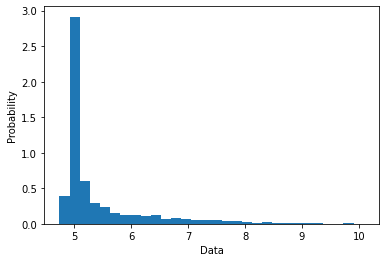


running on  GCNNet_kiba
data/processed/kiba_test.pt
Pre-processed data found: data/processed/kiba_test.pt, loading ...
predicting for test data
Make prediction for 19709 samples...
              precision    recall  f1-score   support

         0.0       0.71      0.64      0.68      4080
         1.0       0.91      0.93      0.92     15629

    accuracy                           0.87     19709
   macro avg       0.81      0.79      0.80     19709
weighted avg       0.87      0.87      0.87     19709

specificity:  0.6441176470588236
sensivity:  0.9310896410518907
f1:  0.9200518445926722


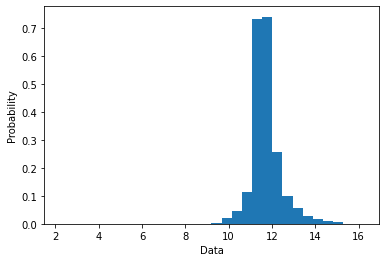

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sys, os
from random import shuffle
import torch
import torch.nn as nn
from models.gat import GATNet
from models.gat_gcn import GAT_GCN
from models.gcn import GCNNet
from models.ginconv import GINConvNet

%matplotlib inline

datasets = ['davis','kiba']
modeling = GCNNet
model_st = modeling.__name__

cuda_name = "cuda:0"
print('cuda_name:', cuda_name)

TEST_BATCH_SIZE = 512
LR = 0.0005
LOG_INTERVAL = 20
NUM_EPOCHS = 1000

print('Learning rate: ', LR)
print('Epochs: ', NUM_EPOCHS)

# Main program: iterate over different datasets
for dataset in datasets:
    print('\nrunning on ', model_st + '_' + dataset )
    processed_data_file_test = 'data/processed/' + dataset + '_test.pt'
    if ((not os.path.isfile(processed_data_file_test))):
        print('please run create_data.py to prepare data in pytorch format!')
    else:
        test_data = TestbedDataset(root='data', dataset=dataset+'_test')

        
        # make data PyTorch mini-batch processing ready
        test_loader = DataLoader(test_data, batch_size=TEST_BATCH_SIZE, shuffle=False)

        # training the model
        device = torch.device(cuda_name if torch.cuda.is_available() else "cpu")
        model = modeling().to(device)
        model_file_name = 'model_' + model_st + '_' + dataset +  '.model'
        model.load_state_dict(torch.load(model_file_name))
        print('predicting for test data')
        G,P = predicting(model, device, test_loader)
        if dataset  == 'kiba':
            pkd  = 12.1
        elif dataset  == 'davis':
            pkd  = 7
        plt.hist(P, density=True, bins=30)
        plt.ylabel('Probability')
        plt.xlabel('Data');
        classification(G,P,pkd)
        plt.show()


### **Weighted:** 

cuda_name: cuda:0
Learning rate:  0.0005
Epochs:  1000

running on  GCNNet_davis
data/processed/davis_test.pt
Pre-processed data found: data/processed/davis_test.pt, loading ...
predicting for test data
Make prediction for 5010 samples...
              precision    recall  f1-score   support

         0.0       0.69      0.57      0.62       417
         1.0       0.96      0.98      0.97      4593

    accuracy                           0.94      5010
   macro avg       0.83      0.77      0.80      5010
weighted avg       0.94      0.94      0.94      5010

specificity:  0.5683453237410072
sensivity:  0.977139124755062
f1:  0.9692257855523161


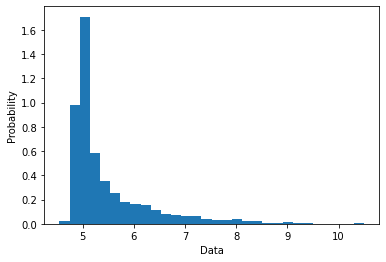


running on  GCNNet_kiba
data/processed/kiba_test.pt
Pre-processed data found: data/processed/kiba_test.pt, loading ...
predicting for test data
Make prediction for 19709 samples...
              precision    recall  f1-score   support

         0.0       0.47      0.78      0.59      4080
         1.0       0.93      0.77      0.84     15629

    accuracy                           0.77     19709
   macro avg       0.70      0.77      0.71     19709
weighted avg       0.84      0.77      0.79     19709

specificity:  0.7791666666666667
sensivity:  0.7705547379870753
f1:  0.8429636369999649


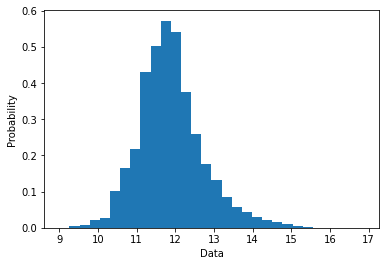

In [17]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sys, os
from random import shuffle
import torch
import torch.nn as nn
from models.gat import GATNet
from models.gat_gcn import GAT_GCN
from models.gcn import GCNNet
from models.ginconv import GINConvNet

%matplotlib inline

datasets = ['davis','kiba']
modeling = GCNNet
model_st = modeling.__name__

cuda_name = "cuda:0"
print('cuda_name:', cuda_name)

TEST_BATCH_SIZE = 512
LR = 0.0005
LOG_INTERVAL = 20
NUM_EPOCHS = 1000

print('Learning rate: ', LR)
print('Epochs: ', NUM_EPOCHS)

# Main program: iterate over different datasets
for dataset in datasets:
    print('\nrunning on ', model_st + '_' + dataset )
    processed_data_file_test = 'data/processed/' + dataset + '_test.pt'
    if ((not os.path.isfile(processed_data_file_test))):
        print('please run create_data.py to prepare data in pytorch format!')
    else:
        test_data = TestbedDataset(root='data', dataset=dataset+'_test')

        
        # make data PyTorch mini-batch processing ready
        test_loader = DataLoader(test_data, batch_size=TEST_BATCH_SIZE, shuffle=False)

        # training the model
        device = torch.device(cuda_name if torch.cuda.is_available() else "cpu")
        model = modeling().to(device)
        model_file_name = 'model_' + model_st + '_' + dataset +  '_weighted.model'
        model.load_state_dict(torch.load(model_file_name))
        # loss_fn = nn.MSELoss()
        # optimizer = torch.optim.Adam(model.parameters(), lr=LR)
        # best_mse = 1000
        # best_test_mse = 1000
        # best_test_ci = 0
        # best_epoch = -1
        print('predicting for test data')
        G,P = predicting(model, device, test_loader)
        if dataset  == 'kiba':
            pkd  = 12.1
        elif dataset  == 'davis':
            pkd  = 7
        plt.hist(P, density=True, bins=30)
        plt.ylabel('Probability')
        plt.xlabel('Data');
        classification(G,P,pkd)
        plt.show()
